In [1]:
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Example for Brain Age Prediction

In [6]:
# Example
# Note: the example model checkpoint works with UK Biobank T1_brain_linearto_MNI.nii.gz files
# Example for Brain Age Prediction
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = './brain_age/run_20190719_00_epoch_best_mae.p'
# Option 1: Specify device explicitly
model.load_state_dict(torch.load(fp_, weights_only=False, map_location='cpu'))
# Then move to GPU if needed
model.cuda()

# Example data: some random brain in the MNI152 1mm std space
data = np.random.rand(182, 218, 182)
label = np.array([71.3,]) # Assuming the random subject is 71.3-year-old.

# Transforming the age to soft label (probability distribution)
bin_range = [42,82]
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

# Preprocessing
data = data/data.mean()
data = dpu.crop_center(data, (160, 192, 160))

# Move the data from numpy to torch tensor on GPU
sp = (1,1)+data.shape
data = data.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32).cuda()
print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Evaluation
model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    output = model(input_data)

# Output, loss, visualisation
x = output[0].cpu().reshape([1, -1])
print(f'Output shape: {x.shape}')
loss = dpl.my_KLDivLoss(x, y).numpy()

# Prediction, Visualisation and Summary
x = x.numpy().reshape(-1)
y = y.numpy().reshape(-1)

plt.bar(bc, y)
plt.title('Soft label')
plt.show()

prob = np.exp(x)
pred = prob@bc
plt.bar(bc, prob)
plt.title(f'Prediction: age={pred:.2f}\nloss={loss}')
plt.show()

UnpicklingError: invalid load key, '\xef'.

## CPU version
- Get rid of model.cuda()
- Get rid of data.cuda()
- Deal with [DataParallel issue with CPU](https://discuss.pytorch.org/t/missing-keys-unexpected-keys-in-state-dict-when-loading-self-trained-model/22379)

First bytes of file: b'\xef\xbf\xbd\x02\xef\xbf\xbd\r\nl'
Error loading model: UnpicklingError: invalid load key, '\xef'.
Trying alternative loading method...
Alternative loading also failed: UnpicklingError: invalid load key, '\xbd'.
Please check if the model file is corrupted or in an unexpected format.
[[1.72794232e-176 2.12079862e-164 9.58856469e-153 1.59711513e-141
  9.80160258e-131 2.21662480e-120 1.84750139e-110 5.67605616e-101
  6.42924446e-092 2.68546054e-083 4.13744435e-075 2.35194442e-067
  4.93460624e-060 3.82283107e-053 1.09404740e-046 1.15734053e-040
  4.52869538e-035 6.56085465e-030 3.52299947e-025 7.02193193e-021
  5.20486752e-017 1.43831808e-013 1.48678938e-010 5.77525176e-008
  8.48200413e-006 4.74884237e-004 1.02406859e-002 8.60763746e-002
  2.85288093e-001 3.75947770e-001 1.97398189e-001 4.10984890e-002
  3.35917407e-003 1.06498926e-004 1.29481708e-006 5.97995042e-009
  1.04142250e-011 6.77236045e-015 0.00000000e+000 0.00000000e+000]] [42.5 43.5 44.5 45.5 46.5 47.5 

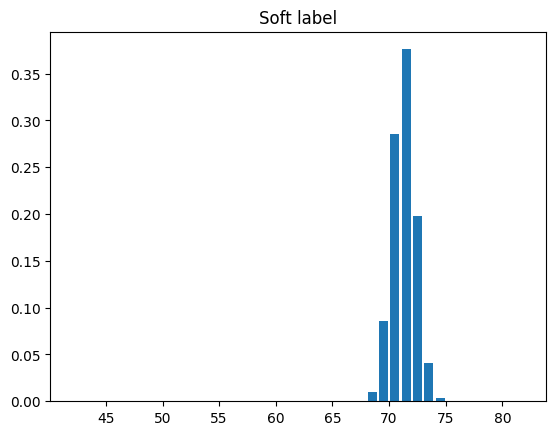

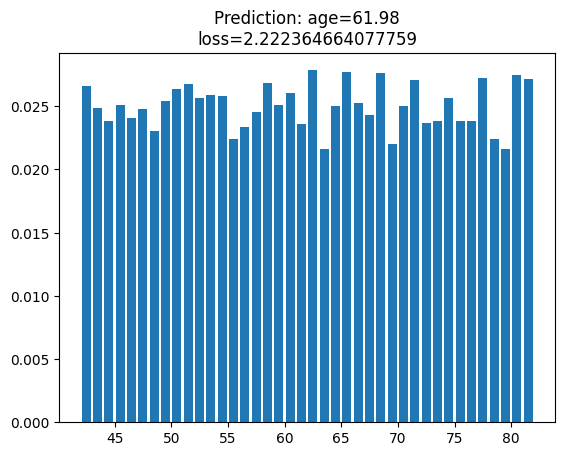

In [17]:
# CPU version
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = './brain_age/run_20190719_00_epoch_best_mae.p'

# Try to diagnose the file issue
try:
    # First, check if the file exists and can be opened
    with open(fp_, 'rb') as f:
        # Read a few bytes to check the file format
        first_bytes = f.read(10)
        print(f"First bytes of file: {first_bytes}")
        f.seek(0)  # Reset file pointer
        
        # Try loading with explicit parameters
        checkpoint = torch.load(
            f, 
            weights_only=False,
            map_location='cpu',
            pickle_module=pickle
        )
    
    # If successful, load the state dict
    model.load_state_dict(checkpoint)
    print("Model loaded successfully!")
    
except Exception as e:
    print(f"Error loading model: {type(e).__name__}: {e}")
    
    # Try an alternative approach if the file might be in a different format
    try:
        print("Trying alternative loading method...")
        import pickle
        with open(fp_, 'rb') as f:
            # Skip potential header bytes if file is corrupted at beginning
            f.seek(2)  # Skip first two bytes which might be problematic
            checkpoint = pickle.load(f)
        
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            model.load_state_dict(checkpoint)
        print("Alternative loading successful!")
    except Exception as e2:
        print(f"Alternative loading also failed: {type(e2).__name__}: {e2}")
        print("Please check if the model file is corrupted or in an unexpected format.")

# Continue with the rest of your code only if model loading was successful


# Example data: some random brain in the MNI152 1mm std space
data = np.random.rand(182, 218, 182)
label = np.array([71.3,]) # Assuming the random subject is 71.3-year-old.

# Transforming the age to soft label (probability distribution)
bin_range = [42,82]
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
print(y, bc)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

# Preprocessing
data = data/data.mean()
data = dpu.crop_center(data, (160, 192, 160))

# Move the data from numpy to torch tensor on GPU
sp = (1,1)+data.shape
data = data.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32)
print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Evaluation
model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    output = model.module(input_data)

# Output, loss, visualisation
x = output[0].reshape([1, -1])
print(f'Output shape: {x.shape}')
loss = dpl.my_KLDivLoss(x, y).numpy()

# Prediction, Visualisation and Summary
x = x.numpy().reshape(-1)
y = y.numpy().reshape(-1)

plt.bar(bc, y)
plt.title('Soft label')
plt.show()

prob = np.exp(x)
pred = prob@bc
plt.bar(bc, prob)
plt.title(f'Prediction: age={pred:.2f}\nloss={loss}')
plt.show()

# Example for Sex Prediction

In [15]:

# Example for Sex Prediction
model = SFCN(output_dim=2, channel_number=[28, 58, 128, 256, 256, 64])
model = torch.nn.DataParallel(model)
fp_ = './sex_prediction/run_20191008_00_epoch_last.p'
model.load_state_dict(torch.load(fp_, weights_only=False))  # Set weights_only=False
model.cuda()


# Example data: some random brain in the MNI152 1mm std space
data = np.random.rand(182, 218, 182)
y = torch.tensor([1]) # Assuming Sex is Male (0=Female, 1=Male)

# Preprocessing
data = data/data.mean()
data = dpu.crop_center(data, (160, 192, 160))

# Move the data from numpy to torch tensor on GPU
sp = (1,1)+data.shape
data = data.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32).cuda()
print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Evaluation
model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    output = model(input_data)

# Output, loss, visualisation
x = output[0].cpu().reshape([1, -1])
loss = F.nll_loss(x, y)

# Prediction, Visualisation and Summary
x = np.exp(x.numpy().reshape(-1))

print('\nPredicted probability: \nFemale\t%.2f%%,\nMale\t%.2f%%'%(x[0]*100, x[1]*100))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.